In [1]:
!pip install nltk rouge bert-score
import nltk
nltk.download('wordnet')  # Needed for METEOR score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Necessary imports
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import single_meteor_score as meteor_score
from rouge import Rouge
from nltk.translate.nist_score import sentence_nist
from bert_score import score as bert_score
import numpy as np

# Function to load texts from a file
def load_texts_from_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        texts = [line.strip() for line in lines]  # Remove any leading/trailing whitespace
    return texts

# Evaluation metrics implementations
def BLEU(reference, hypothesis):
    max_n = len(hypothesis.split())
    for n in range(1, max_n + 1):
        weights = tuple(1 / n for i in range(n))
        score = sentence_bleu([reference.split()], hypothesis.split(), weights)
        if score > 0.01:
            break
    return score

def NIST(reference, hypothesis):
    try:
        # Convert texts to lists of tokens
        ref_tokens = reference.split()
        hyp_tokens = hypothesis.split()
        # Check if hyp_tokens is not empty to prevent ZeroDivisionError
        if len(hyp_tokens) == 0:
            return 0
        # Compute NIST score
        score = sentence_nist([ref_tokens], hyp_tokens)
    except ZeroDivisionError:
        score = 0  # Or another fallback value, depending on your scoring requirements
    return score

# Just making sure the definition is clear and consistent with how you use it
def ROUGE(candidate, reference):
    rouge = Rouge()
    scores = rouge.get_scores(candidate, reference, avg=True, ignore_empty=True)
    return scores['rouge-l']['f']  # Make sure 'scores' contains 'rouge-l'


def Rouge_L(pred, target):
    rouge = Rouge()
    scores = rouge.get_scores(pred, target, avg=True, ignore_empty=True)
    return scores['rouge-l']['f']

def calculate_bert_score(reference, candidate):
    # Notice the order of parameters: references first, candidates second
    P, R, F1 = bert_score([reference], [candidate], lang='en', verbose=True)
    return {'P': P.mean().item(), 'R': R.mean().item(), 'F1': F1.mean().item()}



# Load your texts
reference_texts = load_texts_from_file('/content/drive/MyDrive/references1.txt')
candidate_texts = load_texts_from_file('/content/drive/MyDrive/candidates1.txt')

# Evaluating each pair of texts
scores = {
    'bleu': [],
    'nist': [],
    'rouge': [],
    'rouge_l': [],
    'bert_precision': [],
    'bert_recall': [],
    'bert_f1': []
}

for reference, candidate in zip(reference_texts, candidate_texts):
    if reference and candidate:  # This checks that neither is an empty string
        # Now it's safe to calculate scores
        scores['bleu'].append(BLEU(reference, candidate))
        scores['nist'].append(NIST(reference, candidate))
        scores['rouge'].append(ROUGE(reference, candidate))
        scores['rouge_l'].append(Rouge_L(candidate, reference))
        bert_scores = calculate_bert_score(reference, candidate)  # Use the updated function name here
        scores['bert_precision'].append(bert_scores['P'])
        scores['bert_recall'].append(bert_scores['R'])
        scores['bert_f1'].append(bert_scores['F1'])

# Calculating average scores
avg_scores = {metric: np.mean(values) for metric, values in scores.items()}

# Print average scores
for metric, avg_score in avg_scores.items():
    print(f"Average {metric.upper()} Score: {avg_score}")

# Additional analysis: Variability (Standard Deviation)
std_dev_scores = {metric: np.std(values) for metric, values in scores.items()}
for metric, std_dev in std_dev_scores.items():
    print(f"Standard Deviation of {metric.upper()}: {std_dev}")

In [12]:
import pandas as pd

# Create DataFrame from scores
df_scores = pd.DataFrame(scores)

print(df_scores)

# Save the DataFrame to an Excel file
excel_filename = '/content/drive/MyDrive/results.xlsx'
df_scores.to_excel(excel_filename, index=False)

print(f'Data saved to {excel_filename}')


        bleu      nist     rouge   rouge_l  bert_precision  bert_recall  \
0   1.000000  4.911488  1.000000  1.000000        1.000000     1.000000   
1   1.000000  4.868763  1.000000  1.000000        1.000000     1.000000   
2   0.255319  1.036729  0.225806  0.258065        0.893553     0.880245   
3   0.500000  2.408519  0.646154  0.646154        0.956555     0.932059   
4   0.396226  1.781850  0.523077  0.523077        0.959416     0.905928   
5   0.411765  1.690323  0.530612  0.530612        0.914508     0.905601   
6   0.322581  1.158590  0.450000  0.450000        0.976712     0.894835   
7   0.130435  0.559926  0.190476  0.158730        0.845394     0.851934   
8   1.000000  4.958497  1.000000  1.000000        1.000000     1.000000   
9   0.687500  3.734318  0.729412  0.752941        0.965132     0.953928   
10  0.355556  1.541006  0.508475  0.508475        0.971041     0.922291   
11  0.183673  0.679673  0.425532  0.425532        0.939004     0.882358   
12  0.137931  0.477163  0

In [ ]:
from google.colab import data_table
# Combine average scores and standard deviation into a single dictionary
metrics_data = {
    'Metric': ['BLEU', 'NIST', 'ROUGE', 'ROUGE-L', 'BERT Precision', 'BERT Recall', 'BERT F1'],
    'Average Score': [
        avg_scores['bleu'],
        avg_scores['nist'],
        avg_scores['rouge'],
        avg_scores['rouge_l'],
        avg_scores['bert_precision'],
        avg_scores['bert_recall'],
        avg_scores['bert_f1']
    ],
    'Standard Deviation': [
        std_dev_scores['bleu'],
        std_dev_scores['nist'],
        std_dev_scores['rouge'],
        std_dev_scores['rouge_l'],
        std_dev_scores['bert_precision'],
        std_dev_scores['bert_recall'],
        std_dev_scores['bert_f1']
    ]
}

# Your metrics data seems correctly structured; just convert it into a pandas DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Enable DataTable display for pandas DataFrames within Google Colab
data_table.enable_dataframe_formatter()

# Display the DataFrame as a DataTable
data_table.DataTable(metrics_df, include_index=False)

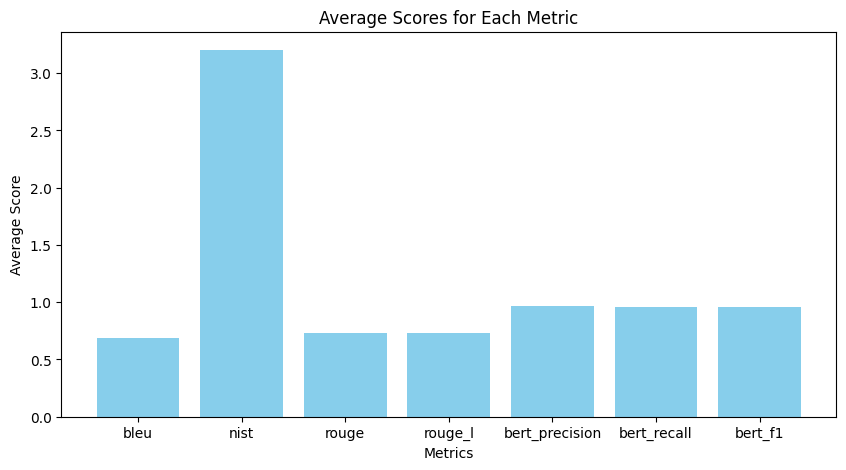

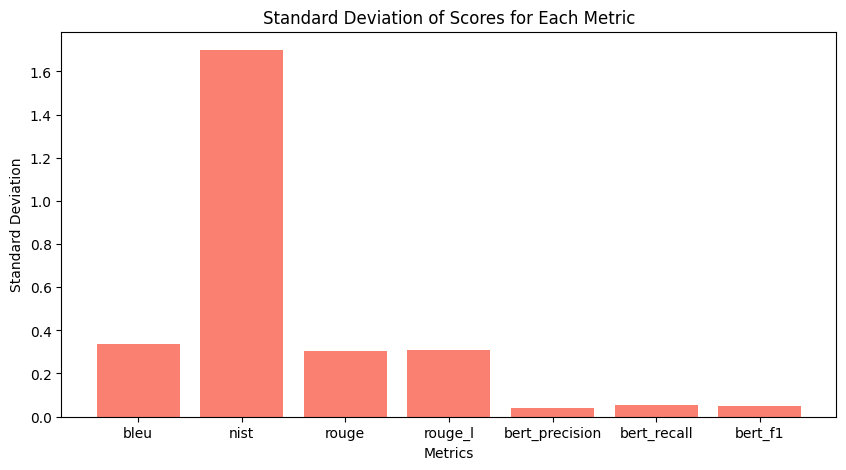

In [8]:
# Importing the required libraries for plotting
import matplotlib.pyplot as plt

# Now we will create two plots: one for average scores and one for standard deviations

# Plotting Average Scores
metrics = list(avg_scores.keys())  # Extracting the metric names
avg_values = list(avg_scores.values())  # Extracting the average values

plt.figure(figsize=[10, 5])  # Setting the figure size
plt.bar(metrics, avg_values, color='skyblue')  # Creating a bar chart
plt.title('Average Scores for Each Metric')  # Adding a title
plt.xlabel('Metrics')  # Adding label for x-axis
plt.ylabel('Average Score')  # Adding label for y-axis
plt.show()  # Displaying the plot

# Plotting Standard Deviation Scores
std_dev_values = list(std_dev_scores.values())  # Extracting the standard deviation values

plt.figure(figsize=[10, 5])  # Setting the figure size
plt.bar(metrics, std_dev_values, color='salmon')  # Creating a bar chart
plt.title('Standard Deviation of Scores for Each Metric')  # Adding a title
plt.xlabel('Metrics')  # Adding label for x-axis
plt.ylabel('Standard Deviation')  # Adding label for y-axis
plt.show()  # Displaying the plot


In [13]:
pip install pandas matplotlib seaborn


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Updated Data with new Seq2Seq chatbot scores
data = {
    'Metric': ['BLEU', 'NIST', 'ROUGE', 'ROUGE_L', 'BERT_PRECISION', 'BERT_RECALL', 'BERT_F1'],
    'OpenAI Chatbot': [0.6906, 3.2024, 0.7332, 0.7330, 0.9671, 0.9530, 0.9598],
    # Updating with provided new Seq2Seq Chatbot scores
    'Seq2Seq Chatbot': [0.3961, 1.6965, 0.5538, 0.5538, 0.9025, 0.8891, 0.8955],

}

# Creating a DataFrame
df = pd.DataFrame(data)

# Setting the 'Metric' column as the index
df.set_index('Metric', inplace=True)

# Displaying the DataFrame for verification
print(df)

# Plotting the performance metrics comparison
plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, fmt=".4f", cmap='viridis')
plt.title('Comparison of Chatbot Performance Metrics')
plt.ylabel('Metric')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()
